In [1]:
'普通nn对比，无自相似的设置'

'普通nn对比，无自相似的设置'

In [2]:
import numpy as np

import torch
import pickle as pkl
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
use_cuda = torch.cuda.is_available()
# device = torch.device('cuda:6') if use_cuda else torch.device('cpu')

In [3]:
'loading data..'
with open('./data/diffusion_process_1d_pt.pkl','rb') as f:
    data = pkl.load(f)[:,:50,:]
data = torch.tensor(data,dtype=torch.float)
data.shape

torch.Size([50, 50, 100])

In [4]:
tgroup = 4
sgroup = 2
data.shape
data = data[:,:int((data.shape[1]-1)//tgroup)*tgroup,:int((data.shape[2])//sgroup)*sgroup]
print(data.shape)
data_x = data[:,:-tgroup,:]
data_y = data[:,tgroup:,:]

torch.Size([50, 48, 100])


In [5]:
batch_size = 16
valid_ratio = 0.2
test_ratio = 0.2
L = data.shape[-1]
cut1 = int((valid_ratio+test_ratio)*data.shape[0])
cut2 =  int(test_ratio*data.shape[0])
print(cut1,cut2)
train_data_x = data_x[:cut1,:,:]
train_data_y = data_y[:cut1,:,:]
valid_data_x = data_x[cut1:cut1+cut2,:,:]
valid_data_y = data_y[cut1:cut1+cut2,:,:]
print(train_data_x.shape,valid_data_x.shape)
# print(dataset1)
dataset1 = torch.utils.data.dataset.TensorDataset(train_data_x, train_data_y)
dataset2 = torch.utils.data.dataset.TensorDataset(valid_data_x, valid_data_y)


train_loader = torch.utils.data.DataLoader(dataset=dataset1,
                                           batch_size=batch_size, 
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=dataset2,
                                           batch_size=batch_size, 
                                           shuffle=True)


20 10
torch.Size([20, 44, 100]) torch.Size([10, 44, 100])


In [6]:
import torch.nn.functional as F
kernel_size = 5
class NormalizedConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,padding,padding_mode):
        super(NormalizedConv1d, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding, padding_mode, bias=False)
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        # 对权重进行归一化 normalize the weight
        normed_weight = self.softmax(self.conv.weight)
        return F.conv1d(x, normed_weight, self.conv.bias, stride=self.conv.stride,
                        padding=self.conv.padding, dilation=self.conv.dilation)

class Diffusion1D(nn.Module):
    def __init__(self,channel=1):
        super(Diffusion1D, self).__init__()
        kernel = kernel_size
        self.normconv = NormalizedConv1d(1, channel, kernel, padding=1, padding_mode='same')
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.normconv(x.unsqueeze(1))

        x = torch.transpose(x,2,1).squeeze()
        return x
    
class TemporalSpatialConv(nn.Module):
    def __init__(self, tgroup = 4, sgroup=2):
        super(TemporalSpatialConv, self).__init__()
        self.tgroup = tgroup
        self.sgroup = sgroup
        # 空间卷积
        self.spatial_conv_weight = nn.Parameter(torch.randn(1, 1, sgroup))
        self.temporal_conv_weight = nn.Parameter(torch.randn(1, 1, tgroup))

        self.spatial_deconv_weight = nn.Parameter(torch.randn(1, 1, sgroup))
        self.temporal_deconv_weight = nn.Parameter(torch.randn(1, 1, tgroup))

        
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        return x
    def Encoder(self, x):

        spatial_conv_weight_normalized = F.softmax(self.spatial_conv_weight, dim=-1)
        temporal_conv_weight_normalized = F.softmax(self.temporal_conv_weight,dim=-1)*self.sgroup

        b,t,l = x.shape
        x = x.reshape(-1,1,l)
        
        x = F.conv1d(x, spatial_conv_weight_normalized, stride=self.sgroup).reshape(b,t,l//self.sgroup)
        x = x.permute(0,2,1)
        x = x.reshape(-1,1,t)
        x = F.conv1d(x, temporal_conv_weight_normalized, stride=self.tgroup).reshape(b,l//self.sgroup,t//self.tgroup)
        x = x.permute(0,2,1)
        return x
    def Decoder(self, x):
        
        spatial_conv_weight_normalized = F.softmax(self.spatial_conv_weight, dim=-1)
        temporal_conv_weight_normalized = F.softmax(self.temporal_conv_weight,dim=-1)

        b,t,l = x.shape
        x = x.reshape(-1,1,l)
        
        x = F.conv_transpose1d(x, spatial_conv_weight_normalized, stride=self.sgroup).reshape(b,t,l*self.sgroup)
        x = x.permute(0,2,1)
        x = x.reshape(-1,1,t)
        x = F.conv_transpose1d(x, temporal_conv_weight_normalized, stride=self.tgroup).reshape(b,l*self.sgroup,t*self.tgroup)
        x = x.permute(0,2,1)

        return x

In [29]:
'load dynamic learner'
seed = 2052
kernel_size = 5
dynamic = torch.load(f'./models/dynamic/diffusion_dynamic_k={kernel_size}_{seed}.pth')
dynamic.eval()
'只有一层卷积不太好控制参数量，先同等参数测试一下，这样微观动力学学习器不需要改,只需要额外学习一个宏观动力学'

'只有一层卷积不太好控制参数量，先同等参数测试一下，这样微观动力学学习器不需要改,只需要额外学习一个宏观动力学'

In [30]:
NEAR_ZERO = 1e-10
tgroup,sgroup

(4, 2)

  0%|                                                                                                                     | 0/10000 [00:00<?, ?it/s]

save
epoch: 0/10000: train loss:2.2916903495788574,valid_loss:2.2955687046051025


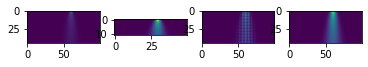

  0%|                                                                                                            | 10/10000 [00:01<13:05, 12.72it/s]

save
epoch: 10/10000: train loss:2.2673028707504272,valid_loss:2.2679507732391357


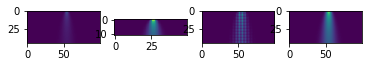

  0%|▏                                                                                                           | 20/10000 [00:01<12:04, 13.78it/s]

save
epoch: 20/10000: train loss:2.2334991693496704,valid_loss:2.2410905361175537


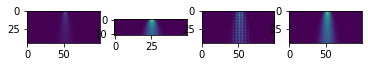

  0%|▎                                                                                                           | 30/10000 [00:02<12:31, 13.27it/s]

save
epoch: 30/10000: train loss:2.2037872076034546,valid_loss:2.2150235176086426


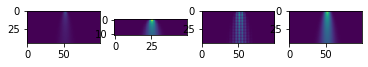

  0%|▍                                                                                                           | 40/10000 [00:03<13:46, 12.05it/s]

save
epoch: 40/10000: train loss:2.178299307823181,valid_loss:2.189732551574707


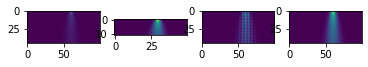

  0%|▌                                                                                                           | 50/10000 [00:04<12:42, 13.04it/s]

save
epoch: 50/10000: train loss:2.1535829305648804,valid_loss:2.1651782989501953


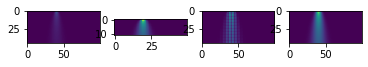

  1%|▋                                                                                                           | 60/10000 [00:05<12:28, 13.29it/s]

save
epoch: 60/10000: train loss:2.1331400871276855,valid_loss:2.1413135528564453


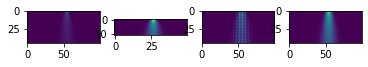

  1%|▊                                                                                                           | 70/10000 [00:06<12:10, 13.60it/s]

save
epoch: 70/10000: train loss:2.1098411083221436,valid_loss:2.11808705329895


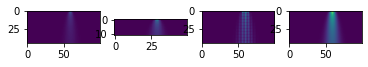

  1%|▊                                                                                                           | 80/10000 [00:07<13:36, 12.15it/s]

save
epoch: 80/10000: train loss:2.0907357931137085,valid_loss:2.09547758102417


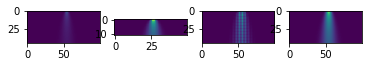

  1%|▉                                                                                                           | 90/10000 [00:08<13:15, 12.46it/s]

save
epoch: 90/10000: train loss:2.0650981664657593,valid_loss:2.0734524726867676


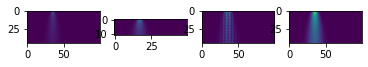

  1%|█                                                                                                          | 100/10000 [00:08<12:10, 13.56it/s]

save
epoch: 100/10000: train loss:2.0471500158309937,valid_loss:2.05196475982666


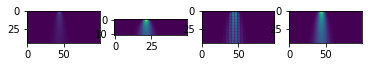

  1%|█▏                                                                                                         | 110/10000 [00:09<11:41, 14.09it/s]

save
epoch: 110/10000: train loss:2.0226186513900757,valid_loss:2.030996322631836


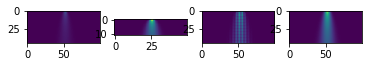

  1%|█▎                                                                                                         | 120/10000 [00:10<12:49, 12.84it/s]

save
epoch: 120/10000: train loss:1.9986329674720764,valid_loss:2.0105504989624023


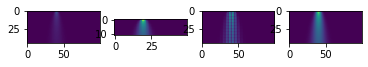

  1%|█▍                                                                                                         | 130/10000 [00:11<13:17, 12.37it/s]

save
epoch: 130/10000: train loss:1.9751730561256409,valid_loss:1.9905799627304077


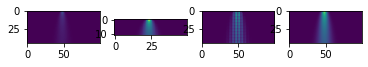

  1%|█▍                                                                                                         | 140/10000 [00:12<12:15, 13.41it/s]

save
epoch: 140/10000: train loss:1.959222435951233,valid_loss:1.9710620641708374


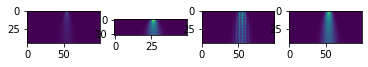

  2%|█▌                                                                                                         | 150/10000 [00:13<11:35, 14.15it/s]

save
epoch: 150/10000: train loss:1.9367417097091675,valid_loss:1.9520161151885986


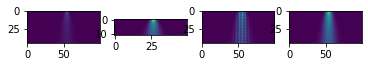

  2%|█▋                                                                                                         | 160/10000 [00:14<12:14, 13.39it/s]

save
epoch: 160/10000: train loss:1.9216625690460205,valid_loss:1.9334194660186768


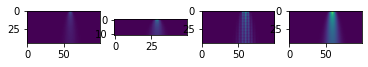

  2%|█▊                                                                                                         | 170/10000 [00:15<11:51, 13.81it/s]

save
epoch: 170/10000: train loss:1.9069620370864868,valid_loss:1.9152165651321411


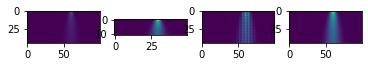

  2%|█▉                                                                                                         | 180/10000 [00:15<11:30, 14.23it/s]

save
epoch: 180/10000: train loss:1.8892187476158142,valid_loss:1.897418737411499


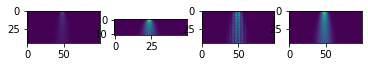

  2%|██                                                                                                         | 190/10000 [00:17<21:43,  7.52it/s]

save
epoch: 190/10000: train loss:1.8718910217285156,valid_loss:1.8800362348556519


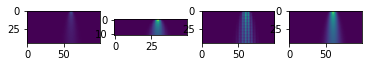

  2%|██▏                                                                                                        | 200/10000 [00:18<13:35, 12.02it/s]

save
epoch: 200/10000: train loss:1.8549599051475525,valid_loss:1.863044023513794


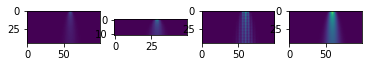

  2%|██▏                                                                                                        | 210/10000 [00:19<11:47, 13.85it/s]

save
epoch: 210/10000: train loss:1.8384353518486023,valid_loss:1.8464633226394653


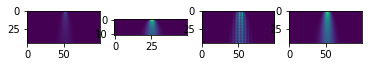

  2%|██▎                                                                                                        | 220/10000 [00:20<12:51, 12.67it/s]

save
epoch: 220/10000: train loss:1.8190261721611023,valid_loss:1.8302619457244873


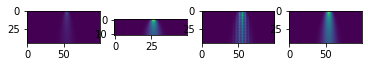

  2%|██▍                                                                                                        | 230/10000 [00:21<12:47, 12.72it/s]

save
epoch: 230/10000: train loss:1.8033220171928406,valid_loss:1.8144723176956177


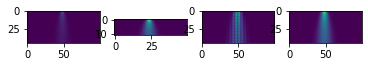

  2%|██▌                                                                                                        | 240/10000 [00:21<12:03, 13.49it/s]

save
epoch: 240/10000: train loss:1.7880008220672607,valid_loss:1.7990520000457764


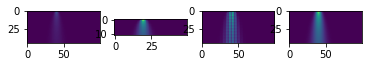

  2%|██▋                                                                                                        | 250/10000 [00:22<11:37, 13.98it/s]

save
epoch: 250/10000: train loss:1.7762292623519897,valid_loss:1.7839969396591187


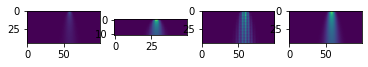

  3%|██▊                                                                                                        | 260/10000 [00:23<11:23, 14.25it/s]

save
epoch: 260/10000: train loss:1.7647695541381836,valid_loss:1.7693288326263428


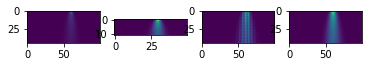

  3%|██▉                                                                                                        | 270/10000 [00:24<11:18, 14.34it/s]

save
epoch: 270/10000: train loss:1.7443144917488098,valid_loss:1.7550244331359863


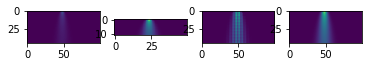

  3%|██▉                                                                                                        | 280/10000 [00:25<11:22, 14.25it/s]

save
epoch: 280/10000: train loss:1.7305010557174683,valid_loss:1.7410868406295776


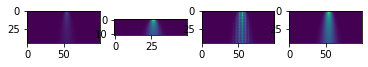

  3%|███                                                                                                        | 290/10000 [00:25<11:20, 14.26it/s]

save
epoch: 290/10000: train loss:1.7200796604156494,valid_loss:1.7275246381759644


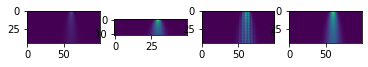

  3%|███▏                                                                                                       | 300/10000 [00:26<11:13, 14.40it/s]

save
epoch: 300/10000: train loss:1.7069546580314636,valid_loss:1.7143052816390991


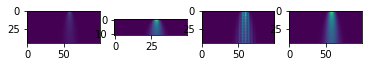

  3%|███▎                                                                                                       | 310/10000 [00:27<11:11, 14.44it/s]

save
epoch: 310/10000: train loss:1.6971375942230225,valid_loss:1.701471209526062


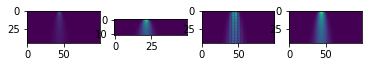

  3%|███▍                                                                                                       | 320/10000 [00:28<11:11, 14.42it/s]

save
epoch: 320/10000: train loss:1.6789327263832092,valid_loss:1.6890053749084473


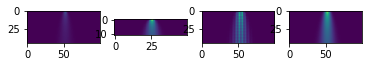

  3%|███▌                                                                                                       | 330/10000 [00:29<11:48, 13.65it/s]

save
epoch: 330/10000: train loss:1.6641075015068054,valid_loss:1.6769139766693115


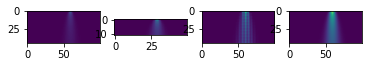

  3%|███▋                                                                                                       | 340/10000 [00:30<11:33, 13.92it/s]

save
epoch: 340/10000: train loss:1.6581535339355469,valid_loss:1.6651619672775269


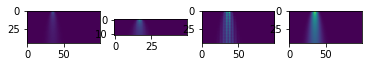

  4%|███▋                                                                                                       | 350/10000 [00:30<11:17, 14.24it/s]

save
epoch: 350/10000: train loss:1.6468221545219421,valid_loss:1.6537196636199951


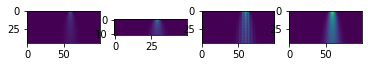

  4%|███▊                                                                                                       | 360/10000 [00:31<11:09, 14.41it/s]

save
epoch: 360/10000: train loss:1.6303977966308594,valid_loss:1.6426246166229248


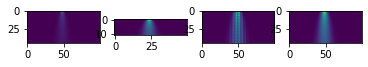

  4%|███▉                                                                                                       | 370/10000 [00:32<11:20, 14.16it/s]

save
epoch: 370/10000: train loss:1.627864956855774,valid_loss:1.6318837404251099


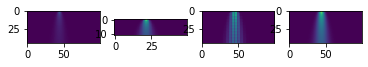

  4%|████                                                                                                       | 380/10000 [00:33<11:09, 14.37it/s]

save
epoch: 380/10000: train loss:1.6122557520866394,valid_loss:1.6214579343795776


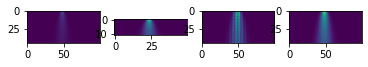

  4%|████▏                                                                                                      | 390/10000 [00:34<11:16, 14.20it/s]

save
epoch: 390/10000: train loss:1.6049004793167114,valid_loss:1.6113718748092651


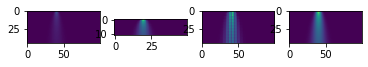

  4%|████▎                                                                                                      | 400/10000 [00:34<11:07, 14.39it/s]

save
epoch: 400/10000: train loss:1.5952529311180115,valid_loss:1.6016219854354858


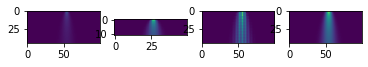

  4%|████▍                                                                                                      | 410/10000 [00:35<11:07, 14.37it/s]

save
epoch: 410/10000: train loss:1.5859455466270447,valid_loss:1.5922133922576904


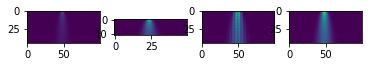

  4%|████▍                                                                                                      | 420/10000 [00:36<11:07, 14.36it/s]

save
epoch: 420/10000: train loss:1.576928734779358,valid_loss:1.5830771923065186


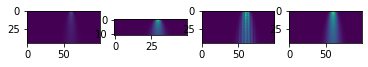

  4%|████▌                                                                                                      | 430/10000 [00:37<11:06, 14.35it/s]

save
epoch: 430/10000: train loss:1.5658388137817383,valid_loss:1.574257493019104


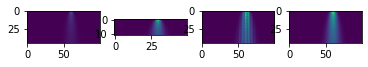

  4%|████▋                                                                                                      | 440/10000 [00:38<11:06, 14.35it/s]

save
epoch: 440/10000: train loss:1.5598347783088684,valid_loss:1.5657576322555542


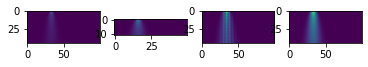

  4%|████▊                                                                                                      | 450/10000 [00:38<11:17, 14.10it/s]

save
epoch: 450/10000: train loss:1.5494511723518372,valid_loss:1.5575467348098755


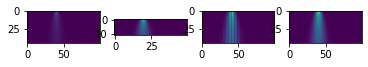

  5%|████▉                                                                                                      | 460/10000 [00:39<11:04, 14.37it/s]

save
epoch: 460/10000: train loss:1.5439645051956177,valid_loss:1.5496704578399658


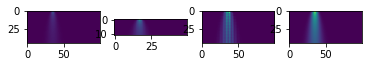

  5%|█████                                                                                                      | 470/10000 [00:40<11:02, 14.39it/s]

save
epoch: 470/10000: train loss:1.534271001815796,valid_loss:1.5420511960983276


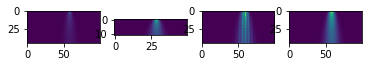

  5%|█████▏                                                                                                     | 480/10000 [00:41<11:09, 14.22it/s]

save
epoch: 480/10000: train loss:1.5313860774040222,valid_loss:1.5347092151641846


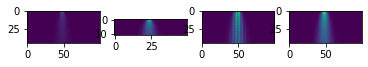

  5%|█████▏                                                                                                     | 490/10000 [00:42<11:03, 14.34it/s]

save
epoch: 490/10000: train loss:1.5243933200836182,valid_loss:1.5276504755020142


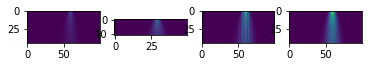

  5%|█████▎                                                                                                     | 500/10000 [00:43<11:08, 14.20it/s]

save
epoch: 500/10000: train loss:1.513579249382019,valid_loss:1.5208563804626465


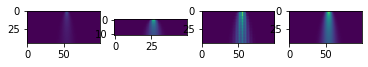

  5%|█████▍                                                                                                     | 510/10000 [00:43<11:03, 14.31it/s]

save
epoch: 510/10000: train loss:1.509231984615326,valid_loss:1.5143542289733887


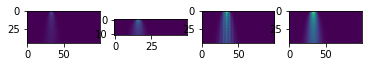

  5%|█████▌                                                                                                     | 520/10000 [00:44<11:02, 14.31it/s]

save
epoch: 520/10000: train loss:1.5031099319458008,valid_loss:1.5081212520599365


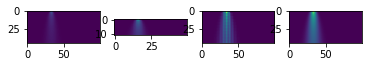

  5%|█████▋                                                                                                     | 530/10000 [00:45<10:59, 14.36it/s]

save
epoch: 530/10000: train loss:1.4953109622001648,valid_loss:1.502097725868225


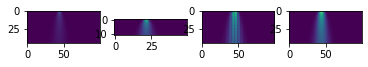

  5%|█████▊                                                                                                     | 540/10000 [00:46<11:03, 14.27it/s]

save
epoch: 540/10000: train loss:1.4915752410888672,valid_loss:1.496347188949585


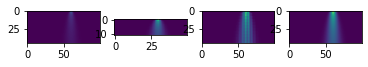

  6%|█████▉                                                                                                     | 550/10000 [00:47<10:58, 14.35it/s]

save
epoch: 550/10000: train loss:1.484389305114746,valid_loss:1.4908592700958252


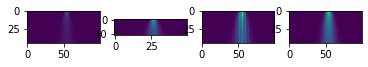

  6%|█████▉                                                                                                     | 560/10000 [00:47<11:12, 14.05it/s]

save
epoch: 560/10000: train loss:1.482822835445404,valid_loss:1.4856144189834595


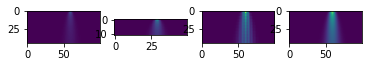

  6%|██████                                                                                                     | 570/10000 [00:48<10:59, 14.30it/s]

save
epoch: 570/10000: train loss:1.4795570373535156,valid_loss:1.4805617332458496


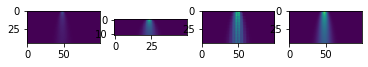

  6%|██████▏                                                                                                    | 580/10000 [00:49<10:53, 14.41it/s]

save
epoch: 580/10000: train loss:1.4714255928993225,valid_loss:1.4757429361343384


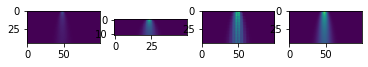

  6%|██████▎                                                                                                    | 590/10000 [00:50<11:26, 13.71it/s]

save
epoch: 590/10000: train loss:1.466951072216034,valid_loss:1.4711576700210571


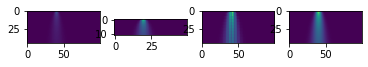

  6%|██████▍                                                                                                    | 600/10000 [00:51<10:59, 14.25it/s]

save
epoch: 600/10000: train loss:1.4610965847969055,valid_loss:1.4667614698410034


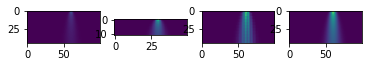

  6%|██████▌                                                                                                    | 610/10000 [00:52<11:07, 14.06it/s]

save
epoch: 610/10000: train loss:1.4586117267608643,valid_loss:1.4625941514968872


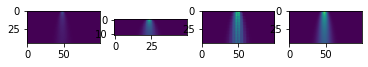

  6%|██████▋                                                                                                    | 620/10000 [00:52<10:52, 14.37it/s]

save
epoch: 620/10000: train loss:1.4547439813613892,valid_loss:1.4586173295974731


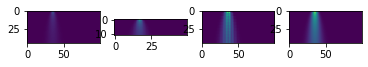

  6%|██████▋                                                                                                    | 630/10000 [00:53<10:51, 14.38it/s]

save
epoch: 630/10000: train loss:1.4510624408721924,valid_loss:1.4548234939575195


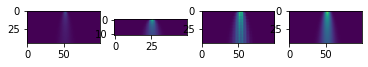

  6%|██████▊                                                                                                    | 640/10000 [00:54<10:58, 14.21it/s]

save
epoch: 640/10000: train loss:1.4461736679077148,valid_loss:1.4512262344360352


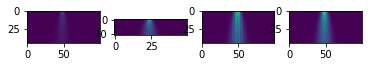

  6%|██████▉                                                                                                    | 650/10000 [00:55<10:49, 14.40it/s]

save
epoch: 650/10000: train loss:1.4429168701171875,valid_loss:1.4478261470794678


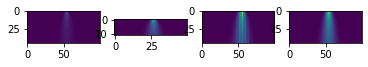

  7%|███████                                                                                                    | 660/10000 [00:56<10:47, 14.42it/s]

save
epoch: 660/10000: train loss:1.43851238489151,valid_loss:1.444588541984558


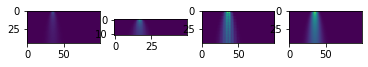

  7%|███████▏                                                                                                   | 670/10000 [00:56<11:00, 14.12it/s]

save
epoch: 670/10000: train loss:1.4381632804870605,valid_loss:1.4415017366409302


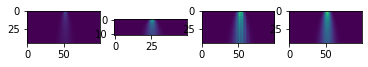

  7%|███████▎                                                                                                   | 680/10000 [00:57<10:51, 14.30it/s]

save
epoch: 680/10000: train loss:1.434101939201355,valid_loss:1.4385650157928467


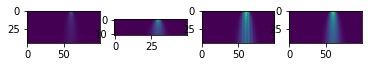

  7%|███████▍                                                                                                   | 690/10000 [00:58<10:46, 14.40it/s]

save
epoch: 690/10000: train loss:1.4326764345169067,valid_loss:1.435813307762146


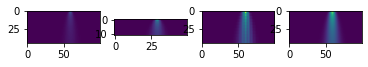

  7%|███████▍                                                                                                   | 700/10000 [00:59<10:44, 14.42it/s]

save
epoch: 700/10000: train loss:1.4290120601654053,valid_loss:1.4332013130187988


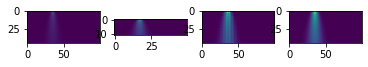

  7%|███████▌                                                                                                   | 710/10000 [01:00<10:47, 14.34it/s]

save
epoch: 710/10000: train loss:1.427796185016632,valid_loss:1.4307364225387573


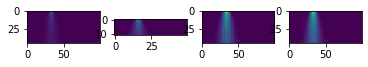

  7%|███████▋                                                                                                   | 720/10000 [01:01<10:53, 14.21it/s]

save
epoch: 720/10000: train loss:1.4255558252334595,valid_loss:1.4283989667892456


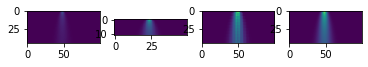

  7%|███████▊                                                                                                   | 730/10000 [01:01<10:46, 14.33it/s]

save
epoch: 730/10000: train loss:1.422411024570465,valid_loss:1.4261963367462158


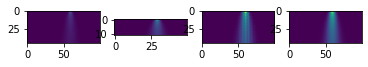

  7%|███████▉                                                                                                   | 740/10000 [01:02<10:48, 14.28it/s]

save
epoch: 740/10000: train loss:1.419475495815277,valid_loss:1.424139142036438


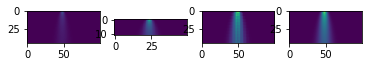

  8%|████████                                                                                                   | 750/10000 [01:03<10:45, 14.33it/s]

save
epoch: 750/10000: train loss:1.417696475982666,valid_loss:1.4222040176391602


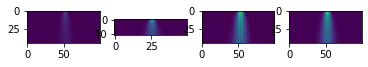

  8%|████████▏                                                                                                  | 760/10000 [01:04<10:44, 14.34it/s]

save
epoch: 760/10000: train loss:1.416963815689087,valid_loss:1.420380711555481


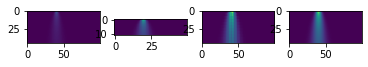

  8%|████████▏                                                                                                  | 770/10000 [01:05<10:46, 14.28it/s]

save
epoch: 770/10000: train loss:1.4162616729736328,valid_loss:1.4186564683914185


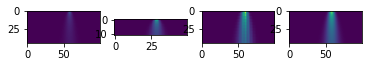

  8%|████████▎                                                                                                  | 780/10000 [01:05<11:02, 13.91it/s]

save
epoch: 780/10000: train loss:1.4138517379760742,valid_loss:1.417023777961731


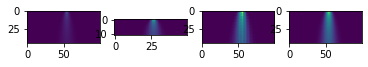

  8%|████████▍                                                                                                  | 790/10000 [01:06<10:44, 14.30it/s]

save
epoch: 790/10000: train loss:1.4132782220840454,valid_loss:1.415502905845642


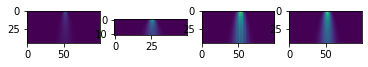

  8%|████████▌                                                                                                  | 800/10000 [01:07<10:38, 14.40it/s]

save
epoch: 800/10000: train loss:1.4111286401748657,valid_loss:1.4140729904174805


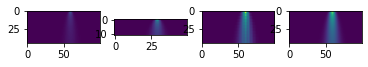

  8%|████████▋                                                                                                  | 810/10000 [01:08<10:38, 14.39it/s]

save
epoch: 810/10000: train loss:1.4099020957946777,valid_loss:1.4127376079559326


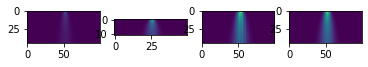

  8%|████████▊                                                                                                  | 820/10000 [01:09<10:46, 14.19it/s]

save
epoch: 820/10000: train loss:1.4087534546852112,valid_loss:1.4114810228347778


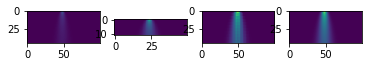

  8%|████████▉                                                                                                  | 830/10000 [01:09<10:46, 14.19it/s]

save
epoch: 830/10000: train loss:1.4076887965202332,valid_loss:1.4103120565414429


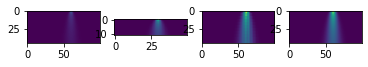

  8%|████████▉                                                                                                  | 840/10000 [01:10<10:39, 14.31it/s]

save
epoch: 840/10000: train loss:1.4073721766471863,valid_loss:1.4092081785202026


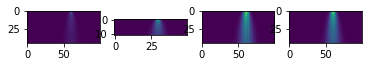

  8%|█████████                                                                                                  | 850/10000 [01:11<10:44, 14.21it/s]

save
epoch: 850/10000: train loss:1.4064136743545532,valid_loss:1.408177375793457


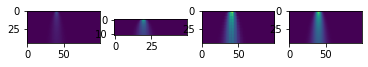

  9%|█████████▏                                                                                                 | 860/10000 [01:12<10:33, 14.42it/s]

save
epoch: 860/10000: train loss:1.405527651309967,valid_loss:1.407222032546997


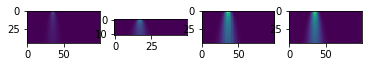

  9%|█████████▎                                                                                                 | 870/10000 [01:13<10:40, 14.25it/s]

save
epoch: 870/10000: train loss:1.405306875705719,valid_loss:1.4063310623168945


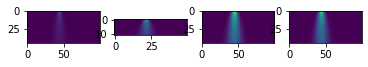

  9%|█████████▍                                                                                                 | 880/10000 [01:14<10:32, 14.42it/s]

save
epoch: 880/10000: train loss:1.4033547043800354,valid_loss:1.4054898023605347


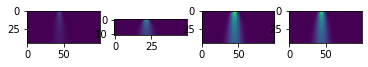

  9%|█████████▌                                                                                                 | 890/10000 [01:14<10:49, 14.03it/s]

save
epoch: 890/10000: train loss:1.403219759464264,valid_loss:1.404713749885559


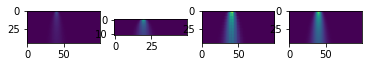

  9%|█████████▋                                                                                                 | 900/10000 [01:15<10:38, 14.25it/s]

save
epoch: 900/10000: train loss:1.4015029072761536,valid_loss:1.4039931297302246


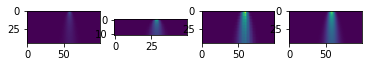

  9%|█████████▋                                                                                                 | 910/10000 [01:16<12:59, 11.66it/s]

save
epoch: 910/10000: train loss:1.401955008506775,valid_loss:1.4033267498016357


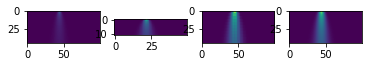

  9%|█████████▊                                                                                                 | 920/10000 [01:17<11:06, 13.61it/s]

save
epoch: 920/10000: train loss:1.401393175125122,valid_loss:1.4027068614959717


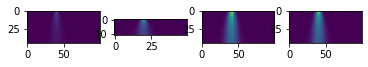

  9%|█████████▉                                                                                                 | 930/10000 [01:18<10:32, 14.34it/s]

save
epoch: 930/10000: train loss:1.4004185795783997,valid_loss:1.4021419286727905


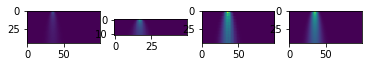

  9%|██████████                                                                                                 | 940/10000 [01:19<10:34, 14.28it/s]

save
epoch: 940/10000: train loss:1.399970531463623,valid_loss:1.4016209840774536


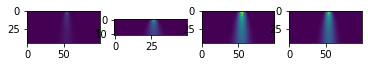

 10%|██████████▏                                                                                                | 950/10000 [01:19<10:31, 14.33it/s]

save
epoch: 950/10000: train loss:1.4004037976264954,valid_loss:1.4011330604553223


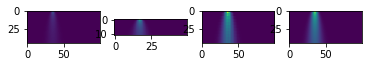

 10%|██████████▎                                                                                                | 960/10000 [01:20<10:28, 14.39it/s]

save
epoch: 960/10000: train loss:1.3991668820381165,valid_loss:1.4006714820861816


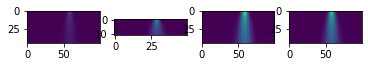

 10%|██████████▍                                                                                                | 970/10000 [01:21<10:24, 14.46it/s]

save
epoch: 970/10000: train loss:1.3988100290298462,valid_loss:1.4002453088760376


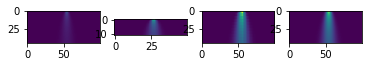

 10%|██████████▍                                                                                                | 980/10000 [01:22<10:24, 14.43it/s]

save
epoch: 980/10000: train loss:1.39848393201828,valid_loss:1.399853229522705


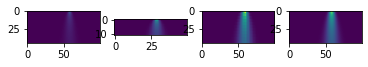

 10%|██████████▌                                                                                                | 990/10000 [01:23<10:29, 14.32it/s]

save
epoch: 990/10000: train loss:1.3985427021980286,valid_loss:1.3995003700256348


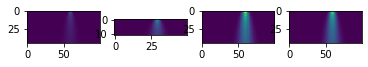

 10%|██████████▌                                                                                               | 1000/10000 [01:23<10:44, 13.96it/s]

save
epoch: 1000/10000: train loss:1.3982551097869873,valid_loss:1.3991681337356567


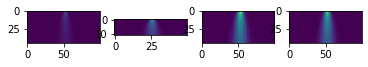

 10%|██████████▋                                                                                               | 1010/10000 [01:24<10:29, 14.29it/s]

save
epoch: 1010/10000: train loss:1.3976796865463257,valid_loss:1.3988703489303589


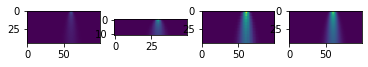

 10%|██████████▊                                                                                               | 1020/10000 [01:25<10:25, 14.35it/s]

save
epoch: 1020/10000: train loss:1.3977686166763306,valid_loss:1.398602843284607


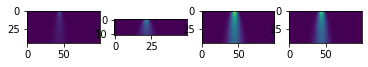

 10%|██████████▉                                                                                               | 1030/10000 [01:26<10:30, 14.23it/s]

save
epoch: 1030/10000: train loss:1.3975532054901123,valid_loss:1.3983473777770996


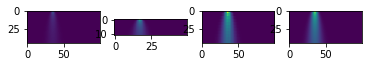

 10%|███████████                                                                                               | 1040/10000 [01:27<10:21, 14.42it/s]

save
epoch: 1040/10000: train loss:1.3970779776573181,valid_loss:1.398109793663025


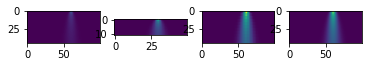

 10%|███████████▏                                                                                              | 1050/10000 [01:28<10:32, 14.16it/s]

save
epoch: 1050/10000: train loss:1.3969098925590515,valid_loss:1.3978914022445679


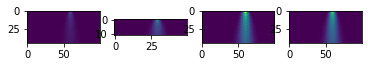

 11%|███████████▏                                                                                              | 1060/10000 [01:28<10:20, 14.40it/s]

save
epoch: 1060/10000: train loss:1.3970065116882324,valid_loss:1.3976906538009644


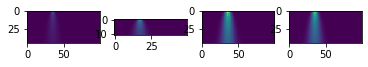

 11%|███████████▎                                                                                              | 1070/10000 [01:29<10:20, 14.38it/s]

save
epoch: 1070/10000: train loss:1.3968578577041626,valid_loss:1.397508978843689


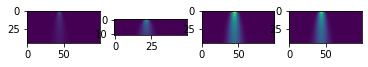

 11%|███████████▍                                                                                              | 1080/10000 [01:30<10:20, 14.38it/s]

save
epoch: 1080/10000: train loss:1.3962736129760742,valid_loss:1.3973448276519775


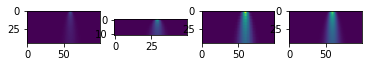

 11%|███████████▌                                                                                              | 1090/10000 [01:31<10:18, 14.41it/s]

save
epoch: 1090/10000: train loss:1.396815001964569,valid_loss:1.397189974784851


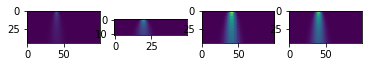

 11%|███████████▋                                                                                              | 1100/10000 [01:32<10:18, 14.39it/s]

save
epoch: 1100/10000: train loss:1.39628666639328,valid_loss:1.3970496654510498


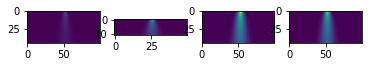

 11%|███████████▊                                                                                              | 1110/10000 [01:32<10:34, 14.00it/s]

save
epoch: 1110/10000: train loss:1.3963876962661743,valid_loss:1.3969190120697021


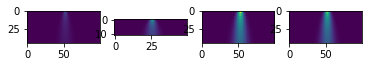

 11%|███████████▊                                                                                              | 1120/10000 [01:33<10:18, 14.35it/s]

save
epoch: 1120/10000: train loss:1.3962961435317993,valid_loss:1.3968003988265991


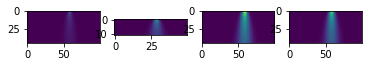

 11%|███████████▉                                                                                              | 1130/10000 [01:34<10:17, 14.37it/s]

save
epoch: 1130/10000: train loss:1.396390438079834,valid_loss:1.3966971635818481


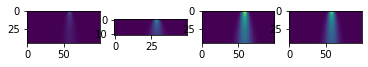

 11%|████████████                                                                                              | 1140/10000 [01:35<10:15, 14.40it/s]

save
epoch: 1140/10000: train loss:1.3961412906646729,valid_loss:1.396596074104309


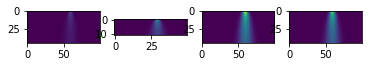

 12%|████████████▏                                                                                             | 1150/10000 [01:36<10:14, 14.40it/s]

save
epoch: 1150/10000: train loss:1.3960756063461304,valid_loss:1.3965084552764893


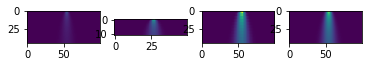

 12%|████████████▎                                                                                             | 1160/10000 [01:36<10:18, 14.29it/s]

save
epoch: 1160/10000: train loss:1.3960193991661072,valid_loss:1.3964316844940186


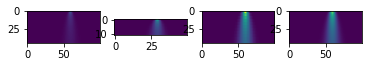

 12%|████████████▍                                                                                             | 1170/10000 [01:37<10:13, 14.39it/s]

save
epoch: 1170/10000: train loss:1.3958252668380737,valid_loss:1.3963592052459717


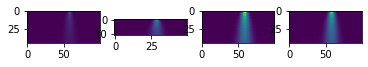

 12%|████████████▌                                                                                             | 1180/10000 [01:38<10:21, 14.20it/s]

save
epoch: 1180/10000: train loss:1.3957850933074951,valid_loss:1.3962924480438232


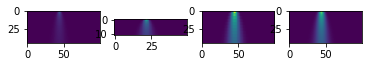

 12%|████████████▌                                                                                             | 1190/10000 [01:39<10:08, 14.48it/s]

save
epoch: 1190/10000: train loss:1.395876407623291,valid_loss:1.3962302207946777


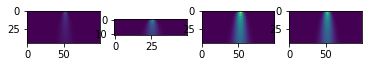

 12%|████████████▋                                                                                             | 1200/10000 [01:40<10:14, 14.31it/s]

save
epoch: 1200/10000: train loss:1.3958377838134766,valid_loss:1.3961740732192993


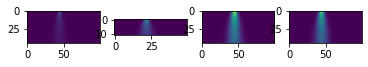

 12%|████████████▊                                                                                             | 1210/10000 [01:40<10:08, 14.45it/s]

save
epoch: 1210/10000: train loss:1.3959195017814636,valid_loss:1.3961238861083984


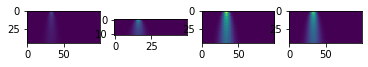

 12%|████████████▉                                                                                             | 1220/10000 [01:41<10:21, 14.13it/s]

save
epoch: 1220/10000: train loss:1.3957721590995789,valid_loss:1.3960747718811035


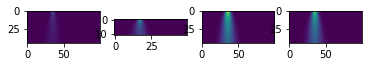

 12%|█████████████                                                                                             | 1230/10000 [01:42<10:10, 14.37it/s]

save
epoch: 1230/10000: train loss:1.3956407308578491,valid_loss:1.3960316181182861


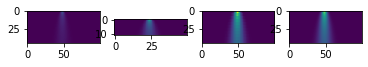

 12%|█████████████▏                                                                                            | 1240/10000 [01:43<10:06, 14.43it/s]

save
epoch: 1240/10000: train loss:1.3957203030586243,valid_loss:1.3959935903549194


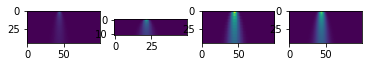

 12%|█████████████▎                                                                                            | 1250/10000 [01:44<10:05, 14.46it/s]

save
epoch: 1250/10000: train loss:1.3956989645957947,valid_loss:1.395959496498108


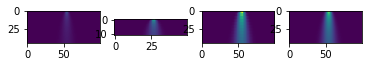

 13%|█████████████▎                                                                                            | 1260/10000 [01:45<10:23, 14.02it/s]

save
epoch: 1260/10000: train loss:1.3955910205841064,valid_loss:1.3959294557571411


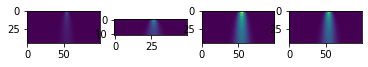

 13%|█████████████▍                                                                                            | 1270/10000 [01:45<10:15, 14.17it/s]

save
epoch: 1270/10000: train loss:1.3954933881759644,valid_loss:1.3959027528762817


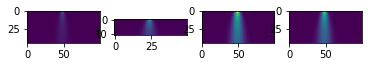

 13%|█████████████▌                                                                                            | 1280/10000 [01:46<10:14, 14.20it/s]

save
epoch: 1280/10000: train loss:1.395567238330841,valid_loss:1.3958756923675537


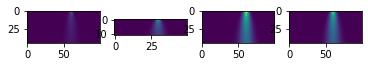

 13%|█████████████▋                                                                                            | 1290/10000 [01:47<10:03, 14.44it/s]

save
epoch: 1290/10000: train loss:1.3955575227737427,valid_loss:1.395851492881775


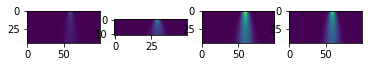

 13%|█████████████▊                                                                                            | 1300/10000 [01:48<10:05, 14.37it/s]

save
epoch: 1300/10000: train loss:1.3956213593482971,valid_loss:1.3958263397216797


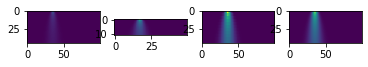

 13%|█████████████▉                                                                                            | 1310/10000 [01:49<10:03, 14.40it/s]

save
epoch: 1310/10000: train loss:1.3955405354499817,valid_loss:1.3958057165145874


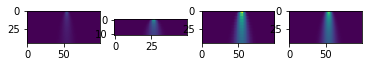

 13%|█████████████▉                                                                                            | 1320/10000 [01:49<10:13, 14.14it/s]

save
epoch: 1320/10000: train loss:1.3956696391105652,valid_loss:1.395790457725525


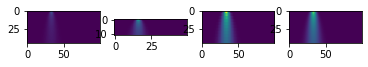

 13%|██████████████                                                                                            | 1330/10000 [01:50<10:42, 13.49it/s]

save
epoch: 1330/10000: train loss:1.3955292701721191,valid_loss:1.3957751989364624


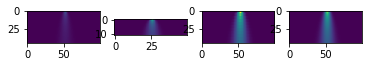

 13%|██████████████▏                                                                                           | 1340/10000 [01:51<10:13, 14.13it/s]

save
epoch: 1340/10000: train loss:1.3955872058868408,valid_loss:1.3957613706588745


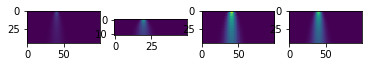

 14%|██████████████▎                                                                                           | 1350/10000 [01:52<10:05, 14.29it/s]

save
epoch: 1350/10000: train loss:1.3955804109573364,valid_loss:1.395747184753418


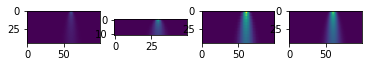

 14%|██████████████▍                                                                                           | 1360/10000 [01:53<11:00, 13.09it/s]

save
epoch: 1360/10000: train loss:1.3955742120742798,valid_loss:1.3957339525222778


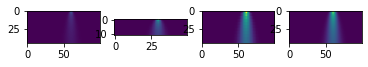

 14%|██████████████▌                                                                                           | 1370/10000 [01:54<10:17, 13.98it/s]

save
epoch: 1370/10000: train loss:1.3955134153366089,valid_loss:1.395721435546875


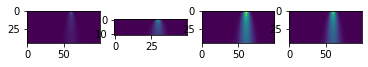

 14%|██████████████▋                                                                                           | 1380/10000 [01:55<10:16, 13.97it/s]

save
epoch: 1380/10000: train loss:1.3955104351043701,valid_loss:1.3957109451293945


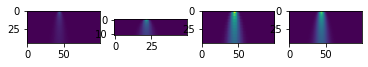

 14%|██████████████▋                                                                                           | 1390/10000 [01:55<10:04, 14.24it/s]

save
epoch: 1390/10000: train loss:1.395508885383606,valid_loss:1.3957041501998901


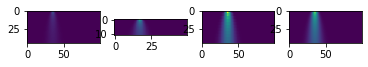

 14%|██████████████▊                                                                                           | 1400/10000 [01:56<10:11, 14.06it/s]

save
epoch: 1400/10000: train loss:1.395555853843689,valid_loss:1.395693302154541


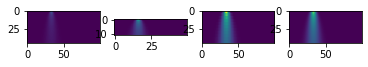

 14%|██████████████▉                                                                                           | 1410/10000 [01:57<09:58, 14.34it/s]

save
epoch: 1410/10000: train loss:1.395457684993744,valid_loss:1.3956823348999023


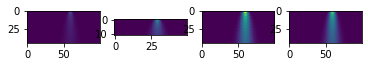

 14%|███████████████                                                                                           | 1420/10000 [01:58<09:54, 14.42it/s]

save
epoch: 1420/10000: train loss:1.3955477476119995,valid_loss:1.395673155784607


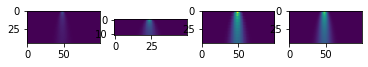

 14%|███████████████▏                                                                                          | 1430/10000 [01:59<09:56, 14.38it/s]

save
epoch: 1430/10000: train loss:1.3955014944076538,valid_loss:1.3956620693206787


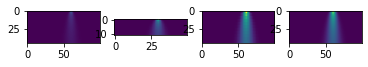

 14%|███████████████▎                                                                                          | 1440/10000 [01:59<10:10, 14.01it/s]

save
epoch: 1440/10000: train loss:1.3955002427101135,valid_loss:1.3956527709960938


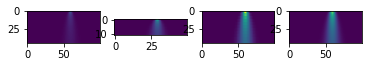

 14%|███████████████▎                                                                                          | 1450/10000 [02:00<10:03, 14.16it/s]

save
epoch: 1450/10000: train loss:1.3954992890357971,valid_loss:1.3956462144851685


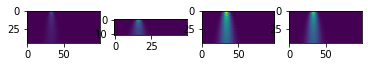

 15%|███████████████▍                                                                                          | 1460/10000 [02:01<09:59, 14.25it/s]

save
epoch: 1460/10000: train loss:1.395498812198639,valid_loss:1.3956400156021118


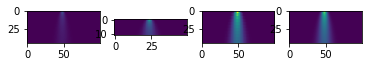

 15%|███████████████▌                                                                                          | 1470/10000 [02:02<09:53, 14.38it/s]

save
epoch: 1470/10000: train loss:1.3955727815628052,valid_loss:1.3956390619277954


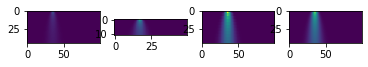

 15%|███████████████▋                                                                                          | 1480/10000 [02:03<10:04, 14.10it/s]

save
epoch: 1480/10000: train loss:1.3954979181289673,valid_loss:1.3956348896026611


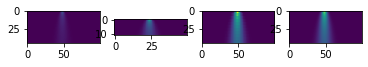

 15%|███████████████▊                                                                                          | 1490/10000 [02:03<10:00, 14.18it/s]

save
epoch: 1490/10000: train loss:1.3955321311950684,valid_loss:1.3956300020217896


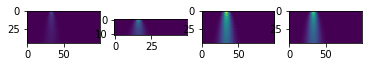

 15%|███████████████▉                                                                                          | 1500/10000 [02:04<09:51, 14.37it/s]

save
epoch: 1500/10000: train loss:1.3955662846565247,valid_loss:1.3956283330917358


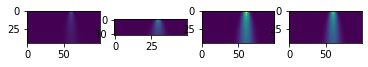

 15%|████████████████                                                                                          | 1510/10000 [02:05<09:52, 14.34it/s]

save
epoch: 1510/10000: train loss:1.395496904850006,valid_loss:1.3956218957901


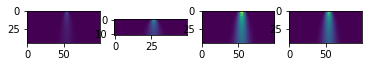

 15%|████████████████                                                                                          | 1520/10000 [02:06<09:50, 14.35it/s]

epoch: 1520/10000: train loss:1.3955296874046326,valid_loss:1.3956218957901


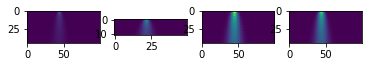

 15%|████████████████▏                                                                                         | 1530/10000 [02:07<09:45, 14.47it/s]

save
epoch: 1530/10000: train loss:1.395496428012848,valid_loss:1.3956204652786255


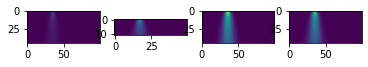

 15%|████████████████▎                                                                                         | 1540/10000 [02:08<09:46, 14.43it/s]

save
epoch: 1540/10000: train loss:1.3955289125442505,valid_loss:1.3956198692321777


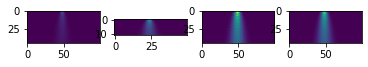

 16%|████████████████▍                                                                                         | 1550/10000 [02:08<10:03, 14.00it/s]

save
epoch: 1550/10000: train loss:1.3955277800559998,valid_loss:1.3956164121627808


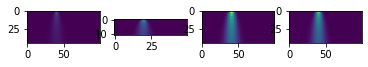

 16%|████████████████▌                                                                                         | 1560/10000 [02:09<09:45, 14.42it/s]

save
epoch: 1560/10000: train loss:1.395495891571045,valid_loss:1.3956117630004883


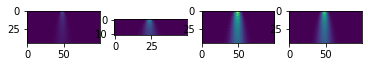

 16%|████████████████▋                                                                                         | 1570/10000 [02:10<09:48, 14.32it/s]

save
epoch: 1570/10000: train loss:1.3954959511756897,valid_loss:1.3956066370010376


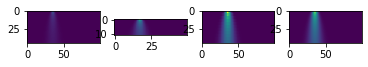

 16%|████████████████▋                                                                                         | 1580/10000 [02:11<09:42, 14.46it/s]

epoch: 1580/10000: train loss:1.3955249786376953,valid_loss:1.3956067562103271


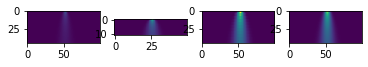

 16%|████████████████▊                                                                                         | 1590/10000 [02:12<09:49, 14.28it/s]

save
epoch: 1590/10000: train loss:1.3955522179603577,valid_loss:1.3956021070480347


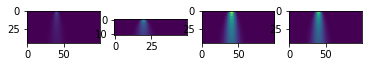

 16%|████████████████▉                                                                                         | 1600/10000 [02:12<09:50, 14.22it/s]

save
epoch: 1600/10000: train loss:1.3954961895942688,valid_loss:1.395595908164978


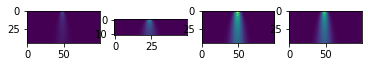

 16%|█████████████████                                                                                         | 1610/10000 [02:13<09:41, 14.43it/s]

save
epoch: 1610/10000: train loss:1.395496428012848,valid_loss:1.3955903053283691


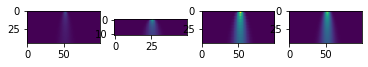

 16%|█████████████████▏                                                                                        | 1620/10000 [02:14<09:41, 14.41it/s]

save
epoch: 1620/10000: train loss:1.3954721093177795,valid_loss:1.3955897092819214


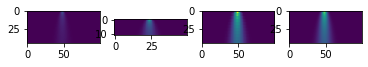

 16%|█████████████████▎                                                                                        | 1630/10000 [02:15<09:43, 14.35it/s]

epoch: 1630/10000: train loss:1.395496428012848,valid_loss:1.3955934047698975


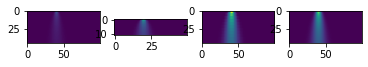

 16%|█████████████████▍                                                                                        | 1640/10000 [02:16<09:37, 14.47it/s]

epoch: 1640/10000: train loss:1.3955221772193909,valid_loss:1.3955953121185303


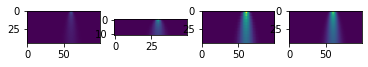

 16%|█████████████████▍                                                                                        | 1650/10000 [02:17<13:43, 10.14it/s]

epoch: 1650/10000: train loss:1.3954960703849792,valid_loss:1.3955929279327393


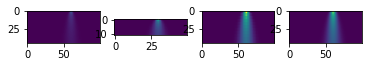

 17%|█████████████████▌                                                                                        | 1660/10000 [02:18<10:48, 12.87it/s]

epoch: 1660/10000: train loss:1.3955217599868774,valid_loss:1.3955937623977661


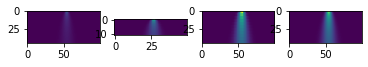

 17%|█████████████████▋                                                                                        | 1670/10000 [02:19<09:42, 14.30it/s]

epoch: 1670/10000: train loss:1.3955206871032715,valid_loss:1.3955897092819214


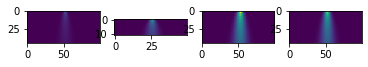

 17%|█████████████████▊                                                                                        | 1680/10000 [02:19<09:36, 14.42it/s]

save
epoch: 1680/10000: train loss:1.3955203890800476,valid_loss:1.3955882787704468


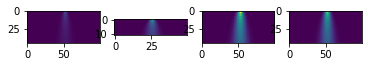

 17%|█████████████████▉                                                                                        | 1690/10000 [02:20<09:41, 14.30it/s]

epoch: 1690/10000: train loss:1.3955201506614685,valid_loss:1.3955888748168945


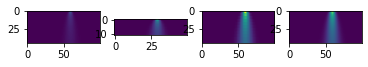

 17%|██████████████████                                                                                        | 1700/10000 [02:21<09:40, 14.31it/s]

save
epoch: 1700/10000: train loss:1.395519733428955,valid_loss:1.395585536956787


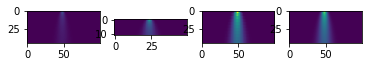

 17%|██████████████████▏                                                                                       | 1710/10000 [02:22<09:59, 13.82it/s]

save
epoch: 1710/10000: train loss:1.3955190181732178,valid_loss:1.3955832719802856


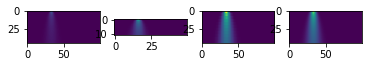

 17%|██████████████████▏                                                                                       | 1720/10000 [02:23<09:48, 14.06it/s]

save
epoch: 1720/10000: train loss:1.3954964876174927,valid_loss:1.3955821990966797


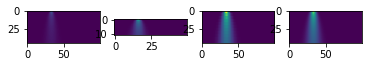

 17%|██████████████████▎                                                                                       | 1730/10000 [02:24<10:00, 13.76it/s]

save
epoch: 1730/10000: train loss:1.3954969644546509,valid_loss:1.3955771923065186


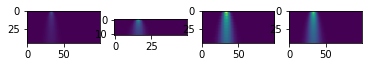

 17%|██████████████████▍                                                                                       | 1740/10000 [02:24<09:38, 14.27it/s]

epoch: 1740/10000: train loss:1.3954970240592957,valid_loss:1.3955774307250977


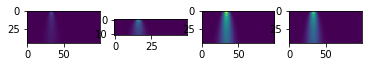

 18%|██████████████████▌                                                                                       | 1750/10000 [02:25<09:34, 14.35it/s]

epoch: 1750/10000: train loss:1.3954969644546509,valid_loss:1.3955780267715454


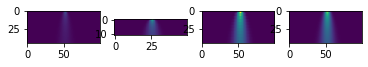

 18%|██████████████████▋                                                                                       | 1760/10000 [02:26<09:40, 14.20it/s]

epoch: 1760/10000: train loss:1.395496904850006,valid_loss:1.3955774307250977


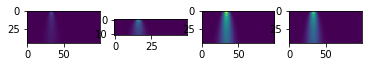

 18%|██████████████████▊                                                                                       | 1770/10000 [02:27<09:46, 14.04it/s]

save
epoch: 1770/10000: train loss:1.395476222038269,valid_loss:1.39557683467865


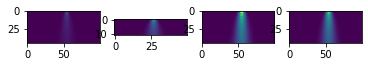

 18%|██████████████████▊                                                                                       | 1780/10000 [02:28<09:33, 14.33it/s]

epoch: 1780/10000: train loss:1.395496666431427,valid_loss:1.3955787420272827


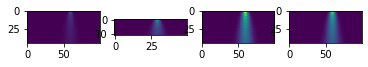

 18%|██████████████████▉                                                                                       | 1790/10000 [02:28<09:30, 14.38it/s]

epoch: 1790/10000: train loss:1.3954961895942688,valid_loss:1.3955832719802856


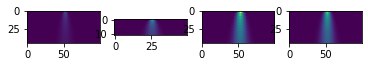

 18%|███████████████████                                                                                       | 1800/10000 [02:29<09:29, 14.39it/s]

epoch: 1800/10000: train loss:1.3955426812171936,valid_loss:1.395585298538208


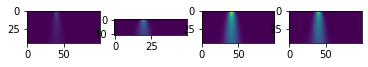

 18%|███████████████████▏                                                                                      | 1810/10000 [02:30<09:32, 14.30it/s]

epoch: 1810/10000: train loss:1.3955411911010742,valid_loss:1.3955817222595215


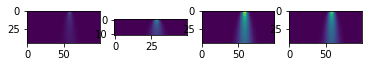

 18%|███████████████████▎                                                                                      | 1820/10000 [02:31<09:34, 14.25it/s]

epoch: 1820/10000: train loss:1.395517647266388,valid_loss:1.3955788612365723


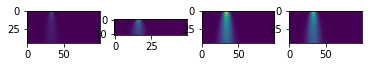

 18%|███████████████████▍                                                                                      | 1830/10000 [02:32<09:29, 14.35it/s]

epoch: 1830/10000: train loss:1.3955182433128357,valid_loss:1.3955817222595215


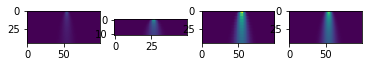

 18%|███████████████████▌                                                                                      | 1840/10000 [02:32<09:28, 14.35it/s]

epoch: 1840/10000: train loss:1.395472526550293,valid_loss:1.3955830335617065


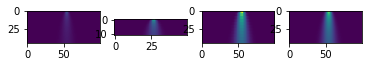

 18%|███████████████████▌                                                                                      | 1850/10000 [02:33<09:31, 14.27it/s]

epoch: 1850/10000: train loss:1.3955193758010864,valid_loss:1.395587682723999


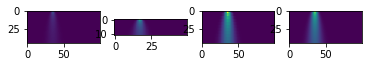

 19%|███████████████████▋                                                                                      | 1860/10000 [02:34<09:24, 14.41it/s]

epoch: 1860/10000: train loss:1.3955188989639282,valid_loss:1.39558744430542


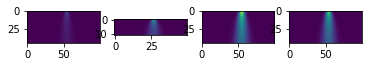

 19%|███████████████████▊                                                                                      | 1870/10000 [02:35<09:21, 14.48it/s]

epoch: 1870/10000: train loss:1.3954946994781494,valid_loss:1.3955843448638916


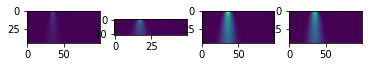

 19%|███████████████████▉                                                                                      | 1880/10000 [02:36<11:14, 12.03it/s]


In [31]:
'coarse graining training...'
loss_kl = torch.nn.KLDivLoss(reduction='batchmean')
num_epochs = 10000

torch.manual_seed(seed)
random.seed(seed)
model = TemporalSpatialConv(tgroup=tgroup, sgroup=sgroup)
model = model.cuda() if use_cuda else model

macro_dynamic = Diffusion1D()
macro_dynamic = macro_dynamic.cuda() if use_cuda else macro_dynamic

optimizer1 = optim.Adam(macro_dynamic.parameters(), lr=1e-3, weight_decay=5e-4)
optimizer2 = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
last_valid_loss = 10000
count = 0
train_losses2 = []
valid_losses2 = []
for epoch in tqdm(range(num_epochs)):
    loss_t2 = []
    loss_v2 = []
    model.train()
    for train_x,train_y in train_loader:
        if use_cuda:
            train_x = train_x.cuda()
            train_y = train_y.cuda()
        encoder = model.Encoder(train_x)
        b,t,l = encoder.shape
        macro_pred = macro_dynamic(encoder.reshape(-1,l)).reshape(b,t,l)
        decoder = model.Decoder(macro_pred)
        b,t,l = decoder.shape
        loss = loss_kl(torch.log(decoder.reshape(-1,l)+NEAR_ZERO),train_y.reshape(-1,l)+NEAR_ZERO)
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        loss.backward()
        optimizer1.step()
        optimizer2.step()
        loss_t2.append(loss.item())
    train_losses2.append(np.mean(loss_t2))

    if epoch % 10 == 0:
        model.eval()
        for valid_x,valid_y in valid_loader:
            if use_cuda:
                valid_x = valid_x.cuda()
                valid_y = valid_y.cuda()
            encoder = model.Encoder(valid_x)
            b,t,l = encoder.shape
            macro_pred = macro_dynamic(encoder.reshape(-1,l)).reshape(b,t,l)
            decoder = model.Decoder(macro_pred)
            b,t,l = decoder.shape
            loss = loss_kl(torch.log(decoder.reshape(-1,l)+NEAR_ZERO),valid_y.reshape(-1,l)+NEAR_ZERO)
            loss_v2.append(loss.item())
        valid_losses2.append(np.mean(loss_v2))

        if np.mean(loss_v2) > last_valid_loss:
            count += 1
            if count > 10:
                break
        if np.mean(loss_v2) < last_valid_loss:
            count = 0
            print('save')
            torch.save({
                'encoder':model,
                'macro_dynamic':macro_dynamic},
                f'./models/diffusion_encoder_macro_unself_sgroup={sgroup}_tgroup={tgroup}_{seed}_k={kernel_size}.pth')
            last_valid_loss = np.mean(loss_v2)

        print(f'epoch: {epoch}/{num_epochs}: train loss:{np.mean(loss_t2)},valid_loss:{np.mean(loss_v2)}')
        plt.subplot(141)
        plt.imshow(valid_x[0])
        plt.subplot(142)
        plt.imshow(encoder[0].detach())
        plt.subplot(143)
        plt.imshow(decoder[0].detach())
        plt.subplot(144)
        plt.imshow(valid_y[0].detach())
        plt.show()


In [32]:
# torch.save({
#     'encoder':model,
#     'macro_dynamic':macro_dynamic},
#     f'./models/diffusion_encoder_macro_unself_sgroup={sgroup}_tgroup={tgroup}_{seed}_k=7.pth')

In [33]:
kernel_size

5

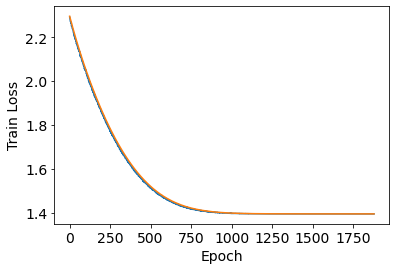

In [34]:
plt.plot(train_losses2)
plt.plot(np.arange(0,len(train_losses2),10),valid_losses2)
# plt.yscale('log')
plt.ylabel('Train Loss',fontsize=14)
plt.xlabel('Epoch',fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

with open(f'./data/loss_unself_{kernel_size}_{seed}.pkl','wb') as f:
    pkl.dump({
        'train':train_losses2,
        'valid':valid_losses2
    },f)

In [35]:
'generate test data'
'1d'
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
# seed = 2050
np.random.seed(seed)
    
# 参数设置
T = 198 # 总时间
dt = 1  # 时间步长
steps = int(T/dt)
space = np.arange(0,98,1)
D =0.5
L = len(space)
pt = np.zeros([steps,L])
center = 40
print(center, L)
pt[0,center] = 1
for step in range(steps-1):
    step = step+1
    pt[step,:] = 1/(np.sqrt(4*np.pi*D*step)) * np.exp(-(space-center)**2/(4*D*step))
pt = torch.tensor(pt,dtype=torch.float)
pt.shape

40 98


torch.Size([198, 98])

In [36]:
from utils import *

In [37]:
'encoder + dynamic + decoder'
encoder = model.Encoder(pt.unsqueeze(0))
print(pt.shape,encoder.shape)
macro_preds = macro_dynamic(encoder[0,:,:])
print(macro_preds.shape)
decoder = model.Decoder(macro_preds.unsqueeze(0))
decoder.shape

torch.Size([198, 98]) torch.Size([1, 49, 49])
torch.Size([49, 49])


torch.Size([1, 196, 98])

In [38]:
'decoder mae'
print('MAE: ',torch.mean(abs(decoder[0,:,:].detach()-pt[2:,:])))

MAE:  tensor(0.0077)


In [24]:
'single单步粗粒化'
encoder = model.Encoder(pt.unsqueeze(0))
print(pt.shape,encoder.shape)
macro_preds = macro_dynamic(encoder[0,:,:])
macro_preds.shape

torch.Size([198, 99]) torch.Size([1, 49, 49])


torch.Size([49, 49])

In [25]:
print('MAE: ',torch.mean(abs(macro_preds[:-1,:].detach()-encoder[0,1:,:].detach())))

MAE:  tensor(0.0002)


In [26]:
encoder = model.Encoder(pt.unsqueeze(0))
print(encoder.shape)
pred_steps = 100
macro_preds = torch.zeros(encoder.shape)[0,:,:]
b,t,l = encoder.shape
macro_preds[0:1,:] = macro_dynamic(encoder[:,0:1,:].reshape(-1,l)).reshape(1,l)
for step in range(pred_steps):
    macro_preds[step+1:step+2] = macro_dynamic(macro_preds[step:step+1,:])
encoder.shape,macro_preds.shape

torch.Size([1, 49, 49])


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


(torch.Size([1, 49, 49]), torch.Size([49, 49]))

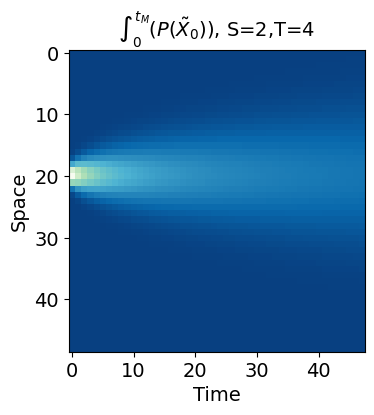

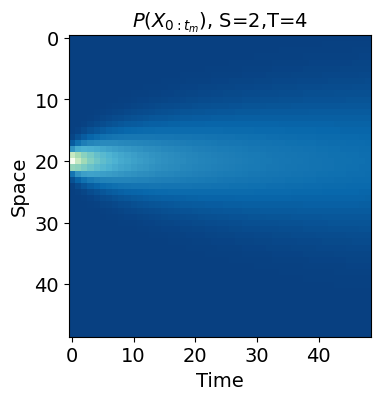

In [30]:
fontsize = 14
plt.figure(dpi=100)
# plt.subplot(121)
plt.imshow(encoder[0,1:,:].detach().T,cmap='GnBu_r')
set_plot_basicinf('Space','Time',fontsize)
plt.title(r'$\int_0^{t_M}(P (\tilde{X}_0))$'+f', S={sgroup},T={tgroup}',fontsize=fontsize)
# plt.show()
plt.figure(dpi=100)
plt.imshow(macro_preds.detach().T,cmap='GnBu_r')
set_plot_basicinf('Space','Time',fontsize)
plt.title(r"$P ({X}_{0:t_m})$"+f', S={sgroup},T={tgroup}',fontsize=fontsize)
plt.show()